In [1]:
%matplotlib notebook
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms, datasets
import torchvision.transforms as transforms
from transform import Resize, RandomZoom, RandomHorizontalFlip

import matplotlib.pyplot as plt
import seaborn as sns
from einops import rearrange, repeat
import numpy as np
import argparse
import os
from data import build_mprage
from train import train
from metrics import dice
from models.unet import UNet

%load_ext autoreload
%autoreload 2

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

/opt/anaconda/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
pre_train_mean = 0.4
pre_train_std = 0.25

In [3]:
transform_train =  transforms.Compose([
                                        Resize(128),
                                        RandomZoom(.15),
                                        RandomHorizontalFlip(.5)
                                    ])

transform_val = transforms.Compose([
                                        Resize(128)
                                    ])

## Train a model

In [4]:
args ={'image_size': 128, 'dim': 3, 'channels': 1, 'classes': 28, 'depth': 4, 'filters': 64, 'norm': 'batchnorm', 'dropout': 0.0, 'name': 'newUNet', 'batch_size': 6, 'epochs': 10, 'learning_rate': 0.003, 'gamma': 0.7, 'gpu': '0', 'seed': 42}

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [6]:
train_set    = build_mprage(root='/scratch/mplatscher/imaging_data/', train=True, train_size=0.8, transform=None)
val_set      = build_mprage(root='/scratch/mplatscher/imaging_data/', train=False, train_size=0.8, transform=None)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=1)
val_loader   = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True, num_workers=1)

/opt/anaconda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [7]:
model = UNet(**args).to(device)

In [8]:
epochs = 10
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=1E-4)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

## load a trained model

In [15]:
PATH = 'data/newUNet_aug.pt'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [16]:
ids = 12

In [17]:
im = torch.tensor(val_set[ids][0][np.newaxis,...], dtype=torch.float).to(device)
out = model(im.to(device))
prediction = torch.argmax(out, dim=1)
target = val_set[ids][1]

<IPython.core.display.Javascript object>


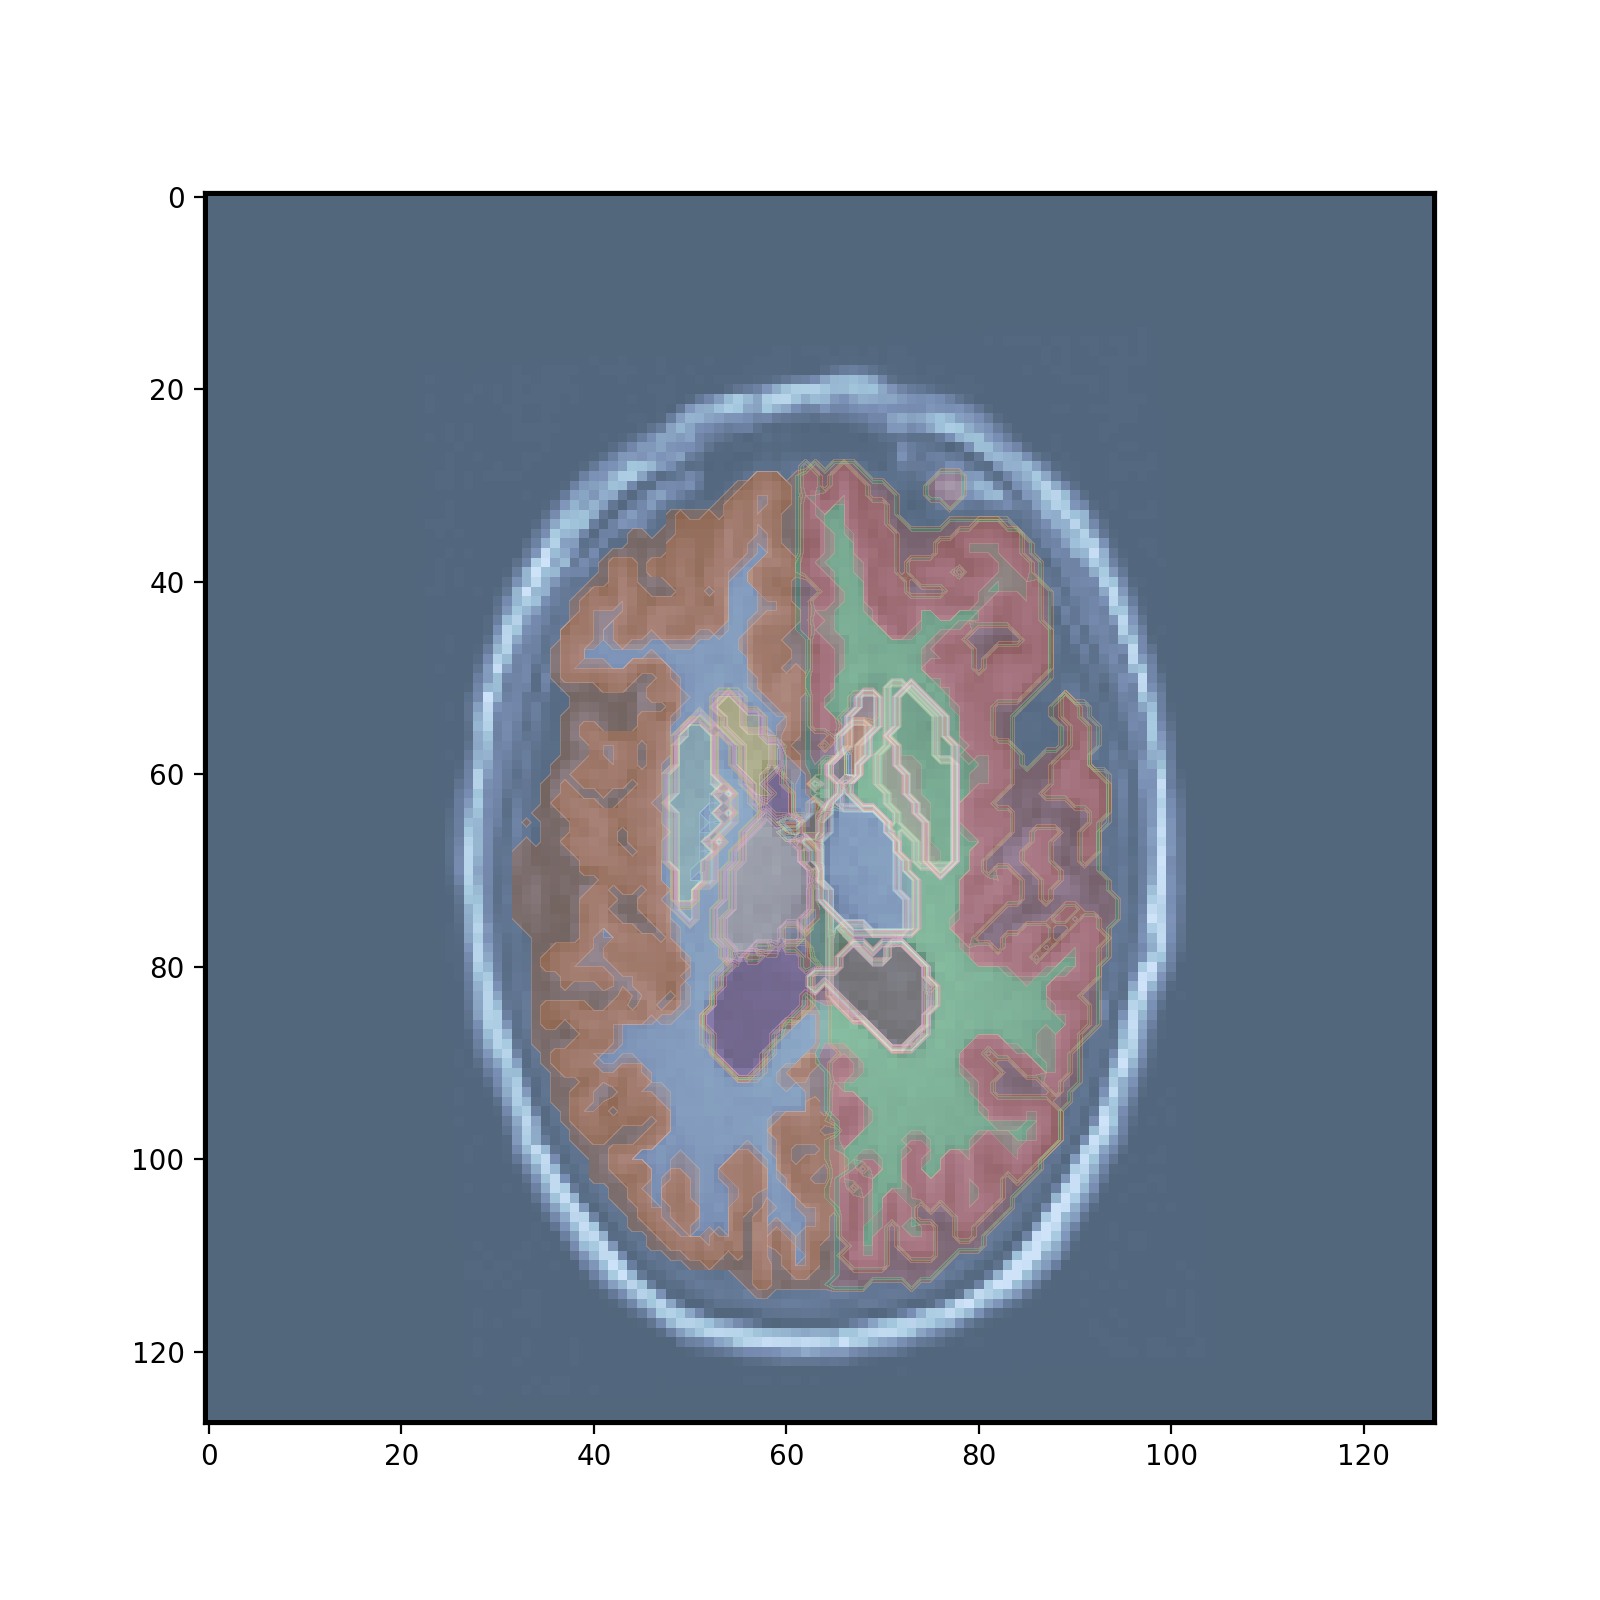

In [23]:
plt.figure(figsize=(8,8))

slc=64

plt.imshow(im.cpu().numpy().squeeze()[:,::-1,slc].T, cmap='bone')

plt.contourf(target.squeeze()[:,::-1,slc].T, alpha=0.3, levels = range(args['classes']), colors=list(sns.color_palette('pastel', args['classes'])))
plt.contourf(prediction.detach().cpu().numpy().squeeze()[:,::-1,slc].T, levels = range(args['classes']),alpha=0.3, colors=list(sns.color_palette('pastel', args['classes'])))
# # plt.contour(prediction[0,1,...].detach().cpu().numpy().squeeze().T, levels=[0.3, 0.5, 0.7], colors=['r'], linewidths=[0.5])

In [24]:
dice(out, target)

ValueError: cannot select an axis to squeeze out which has size not equal to one

In [ ]:
sample = [train_set[0][0], train_set[0][1]]

In [308]:
r = RandomZoom(1.9)

<IPython.core.display.Javascript object>


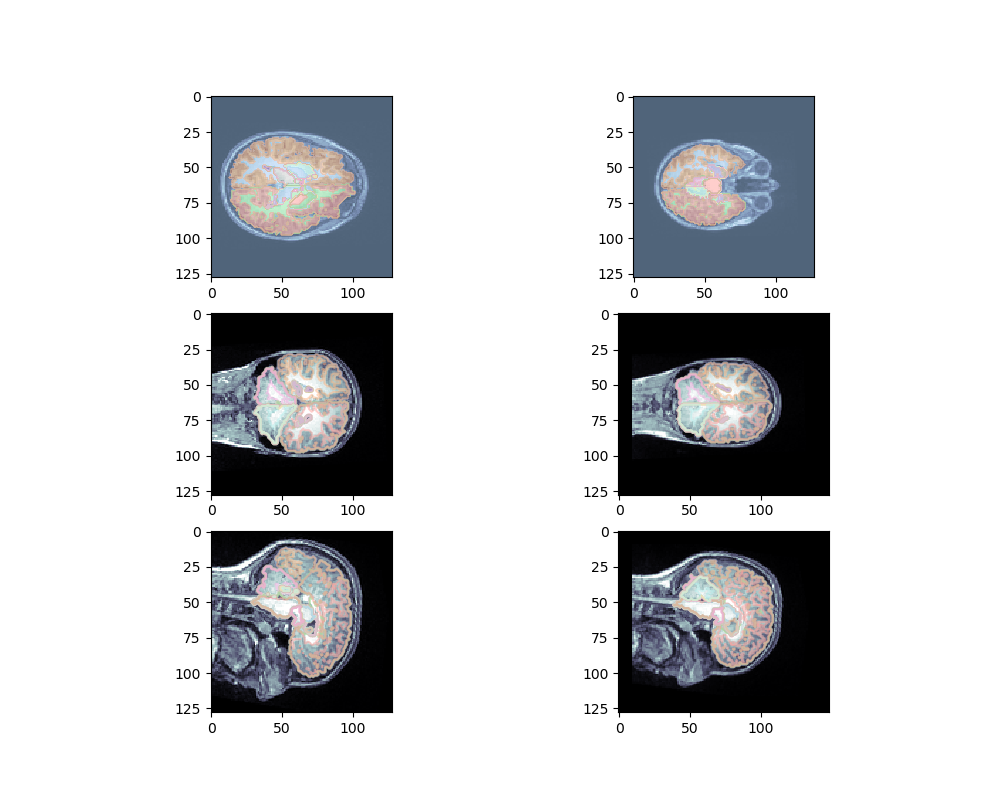

0.8346431565570596 (128, 128, 128)
((10, 11), (10, 11), (10, 11)) (107, 107, 128) (128, 128, 128)


In [309]:
fig, ax = plt.subplots(3,2, figsize=(10,8))

sample_trans = r(sample)
ax[0,0].imshow(sample[0][:,:,64], cmap='bone')
ax[1,0].imshow(sample[0][:,44,:], cmap='bone')
ax[2,0].imshow(sample[0][64,...], cmap='bone')
ax[0,0].contourf(sample[1][:,:,64], levels=np.arange(args['classes']), colors=list(sns.color_palette('pastel', args['classes'])), alpha=.5)
ax[1,0].contour(sample[1][:,44,:], levels=np.arange(args['classes']), colors=list(sns.color_palette('pastel', args['classes'])), alpha=.5)
ax[2,0].contour(sample[1][64,...], levels=np.arange(args['classes']), colors=list(sns.color_palette('pastel', args['classes'])), alpha=.5)



ax[0,1].imshow(sample_trans[0].squeeze()[...,64], cmap='bone')
ax[1,1].imshow(sample_trans[0].squeeze()[:,44,:], cmap='bone')
ax[2,1].imshow(sample_trans[0].squeeze()[64,...], cmap='bone')
ax[0,1].contourf(sample_trans[1].squeeze()[:,:,64], levels=np.arange(args['classes']), colors=list(sns.color_palette('pastel', args['classes'])), alpha=.5)
ax[1,1].contour(sample_trans[1].squeeze()[:,44,:], levels=np.arange(args['classes']), colors=list(sns.color_palette('pastel', args['classes'])), alpha=.5)
ax[2,1].contour(sample_trans[1].squeeze()[64,...], levels=np.arange(args['classes']), colors=list(sns.color_palette('pastel', args['classes'])), alpha=.5)